In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Выполнение лабораторной работы № 2.

**Сучков Василий Вячеславович, группа - ББМО-01-22**

In [2]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.10.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [4]:
!cp drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip -q gtsrb-german-traffic-sign.zip

100% 612M/612M [00:17<00:00, 38.7MB/s]
100% 612M/612M [00:17<00:00, 36.2MB/s]


In [1]:
import cv2
import os
import torch
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent


# Задание 1.Обучить 2 классификатора на основе глубоких нейронных сетейна датасете GTSRB.

В данном датасете больше 20 тыс. тренировочных данных, ресурсы ОЗУ среды colab ограничены, поэтому было принято решение в сборке тернировочного поднабора из 100 представителей каждого класса дорожных знаков.

В качестве моделей нейронных сетей для решения задания классификации, были использованы сеть ResNet50 и VGG16.

В результате данного эесперемента мы должны:
* получить заполенную таблицу с показателями модей во время обучения, валидации и тестирования.
* построить графики функций потерь для данных валидации и тестирования.

Для начала, извлечем картинки для создания тренировочной выборки.


In [3]:
train_path = "Train"
labels = []
data = []
CLASSES = 43
for i in range(CLASSES):
    img_path = os.path.join(train_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)

На выходе, мы получим матричное представление картинки, при этом, данные будут масштабированы для восприятия моделями нейронных сетей.

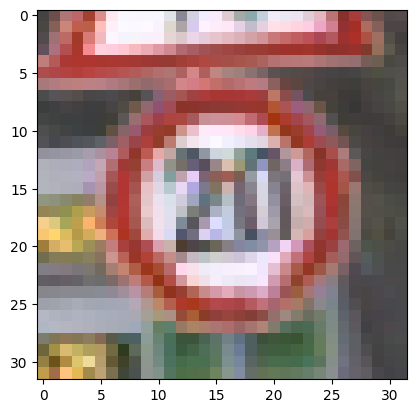

In [4]:
plt.imshow(data[0])

### ResNet50. После разбиения на выборки можно приступить к компиляции модели, единственное, необходимо поменять выходные слои модели, для осуществление классификации 43 типов изображений.

In [5]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

In [6]:
img_size = (224,224)
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False

В результате множества перезапусков обучения, было определено оптимальное значение epochs и batch_size. Для валидации будут выбраны 30 процентов тренировочного набора. При этом, история обучения будет сохранена, для последующего создания графиков

In [7]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 93s 145ms/step - loss: 1.0585 - accuracy: 0.7303 - val_loss: 3.0066 - val_accuracy: 0.2051
Epoch 2/5
429/429 [==============================] - 52s 121ms/step - loss: 0.2063 - accuracy: 0.9456 - val_loss: 0.6915 - val_accuracy: 0.8085
Epoch 3/5
429/429 [==============================] - 62s 145ms/step - loss: 0.1217 - accuracy: 0.9683 - val_loss: 0.2125 - val_accuracy: 0.9387
Epoch 4/5
429/429 [==============================] - 52s 122ms/step - loss: 0.0877 - accuracy: 0.9772 - val_loss: 0.1157 - val_accuracy: 0.9692
Epoch 5/5
429/429 [==============================] - 56s 132ms/step - loss: 0.0637 - accuracy: 0.9834 - val_loss: 0.0869 - val_accuracy: 0.9767


In [8]:
save_model(model, 'ResNet50.h5')
with open('history_ResNet50.pkl', 'wb') as file:
    pickle.dump(history.history, file)
!cp ResNet50.h5 drive/MyDrive/ResNet50.h5

<ipython-input-8-7662eceeb572>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'ResNet50.h5')


Построим необходимые графики, отражающие успешность обучения модели ResNet50. Итоговая точность увеличилась по мере роста числа эпох, однако длаьнейшее увелечение эпох было уже не целесообразно.

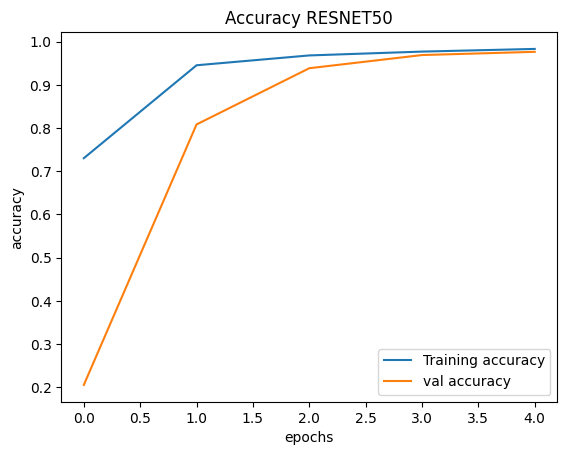

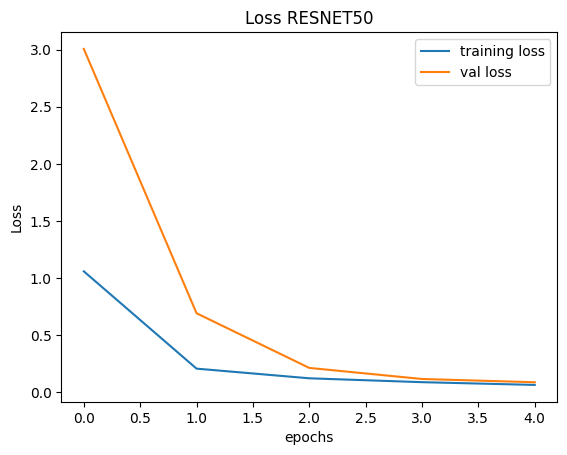

In [9]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy RESNET50")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss RESNET50")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Формируем тестовую выборку немного другим способом, для опрделения правильной метки класса будем использовать csv таблицу с обозначением пути картинки и ее класса.

In [10]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)
data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

Оценим точность модели на тестовой выборке

In [11]:
loss, accuracy = model.evaluate(data, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

395/395 [==============================] - 16s 40ms/step - loss: 0.3758 - accuracy: 0.9154
Test loss: 0.3758074641227722
Test accuracy: 0.9153602719306946


Итоговая точность составила 90 процентов.

### VGG16. Загрузим уже готовый набор данных для тенировки. После разбиения на выборки можно приступить к компиляции модели, единственное, необходимо поменять выходные слои модели, для осуществление классификации 43 типов изображений.

In [12]:
del model
del history
img_size = (224,224)
model = Sequential()
model.add(VGG16(include_top=False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 46s 97ms/step - loss: 4.2956 - accuracy: 0.0943 - val_loss: 2.3912 - val_accuracy: 0.2098
Epoch 2/5
429/429 [==============================] - 43s 101ms/step - loss: 1.4106 - accuracy: 0.5227 - val_loss: 0.7790 - val_accuracy: 0.7178
Epoch 3/5
429/429 [==============================] - 50s 117ms/step - loss: 0.5264 - accuracy: 0.8311 - val_loss: 0.1619 - val_accuracy: 0.9438
Epoch 4/5
429/429 [==============================] - 43s 101ms/step - loss: 0.2343 - accuracy: 0.9421 - val_loss: 0.1296 - val_accuracy: 0.9675
Epoch 5/5
429/429 [==============================] - 45s 105ms/step - loss: 0.1453 - accuracy: 0.9696 - val_loss: 1.3639 - val_accuracy: 0.9162


In [16]:
save_model(model, 'VGG16.h5')
with open('history_VGG16.pkl', 'wb') as file:
    pickle.dump(history.history, file)
!cp ResNet50.h5 drive/MyDrive/ResNet50.h5

<ipython-input-16-dfaa1c6ae2f2>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'VGG16.h5')


Отображаем такиже графики точности и потерь от эпох для модели VGG16

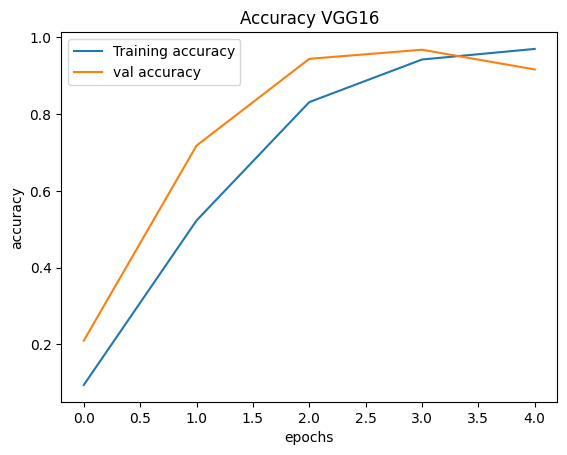

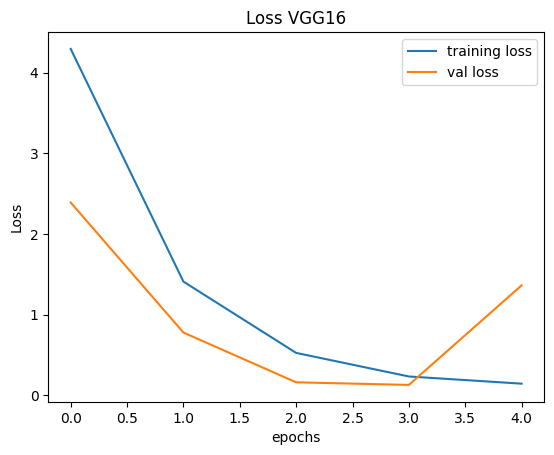

In [14]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy VGG16")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss VGG16")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Проверка точности модели на тестовой выборке и формирование итоговой таблицы для Задания 1

In [15]:
loss, accuracy = model.evaluate(data, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

395/395 [==============================] - 9s 21ms/step - loss: 1.4245 - accuracy: 0.8782
Test loss: 1.4244619607925415
Test accuracy: 0.8782264590263367


Точность модели VGG16 почти 90%, данная статистика будет занесена в таблицу

| Модель   | Обучение | Валидация| Тест |
|----------|----------|----------|------|
| ResNet50 | loss: 0.0637 accuracy: 0.9834 | loss: 0.0869 accuracy: 0.9767  |loss: 0.3758 accuracy: 0.9154|
| VGG16    | loss: 0.1453 accuracy: 0.9696 | loss: 1.3639 accuracy: 0.9162  |loss: 1.4245 accuracy: 0.8782|

# Задание 2. Применить нецелевую атаку уклонения на основе белого ящика против моделей глубокого обучения.

В результате данного эесперемента мы должны:
* получить заполенную таблицу с показателями моделей после применения атаки с опрделенным eps.
* построить графики функций потерь для данных после атаки.

### ResNet50 FGSM. Создаем модель атаки, которая будет основываться на обученном классификаторе для внесения шума в изображение. Для опрделенных eps нужно вывести изображение после атаки, и класс, которые модель предсказала.

In [19]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [20]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.440965347290039
Adv Accuracy: 0.7400000095367432
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.00784313725490196
Adv Loss: 2.591770582199097
Adv Accuracy: 0.6050000190734863
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.011764705882352941
Adv Loss: 3.5671306858062746
Adv Accuracy: 0.49399998784065247
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.01568627450980392
Adv Loss: 4.398491260528565
Adv Accuracy: 0.4020000100135803
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.0196078431372549
Adv Loss: 5.081645603179932
Adv Accuracy: 0.3319999873638153
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.03137254901960784
Adv Loss: 6.415355705261231
Adv Accuracy: 0.21699999272823334
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.0392156862745098
Adv Loss: 6.922237411499023
Adv Accuracy: 0.16500000655651093
True Loss: 0.3387975747585297
True A

In [21]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_rn50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_rn50", adv_accuracises_fgsm)
!cp adv_losses_fgsm_rn50.npy drive/MyDrive/adv_losses_pgd_rn50.npy
!cp adv_accuracises_fgsm_rn50.npy drive/MyDrive/adv_accuracises_fgsm_rn50.npy

Точность с eps = 10/255 = 0,039.. менее 60% и равна 17%. С увелечением eps усиливается зашумление картинки, но следовательно и вероятность обнаружения атаки. Отобразим изображения до и после атаки.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


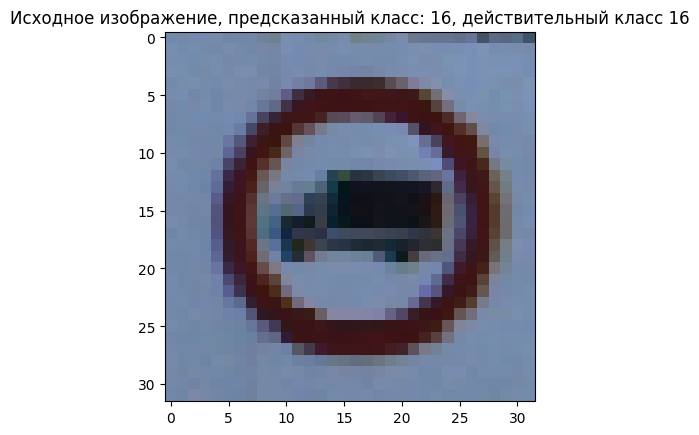

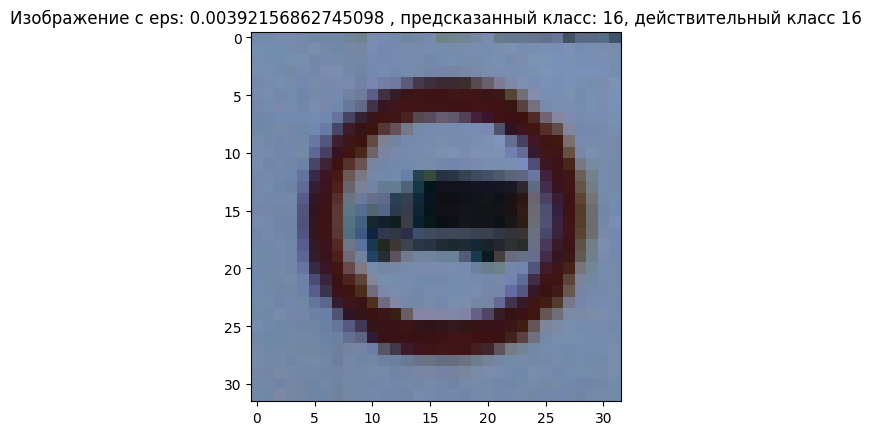

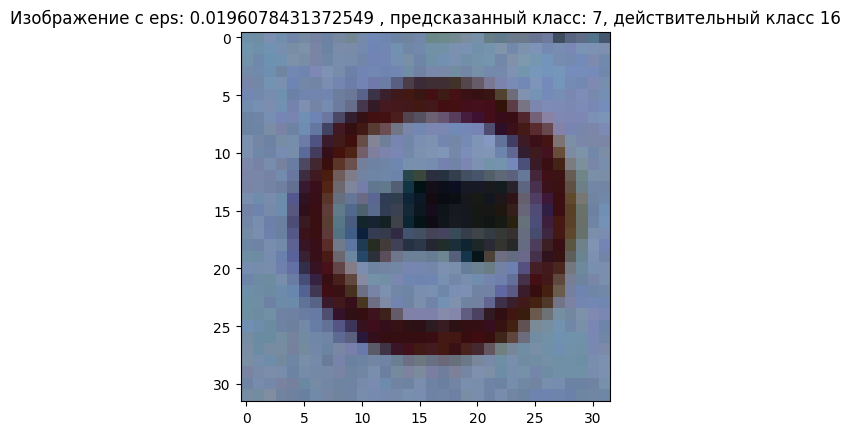

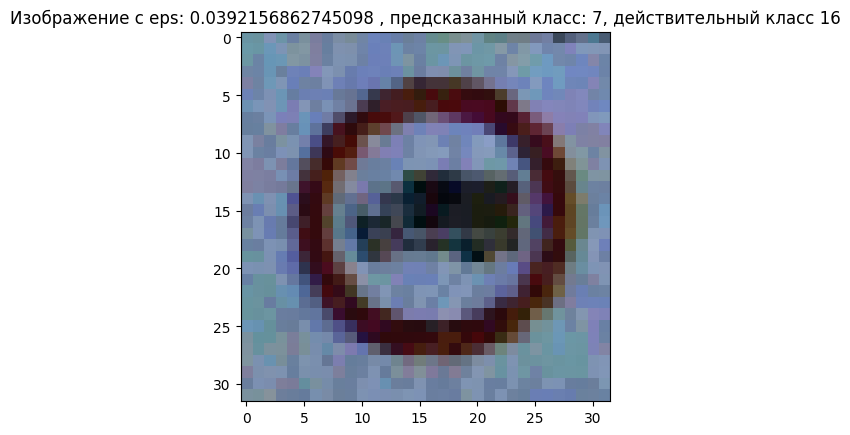

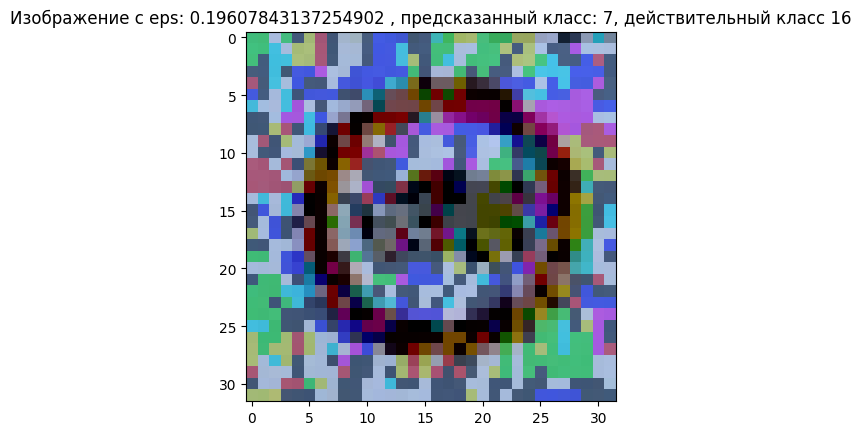

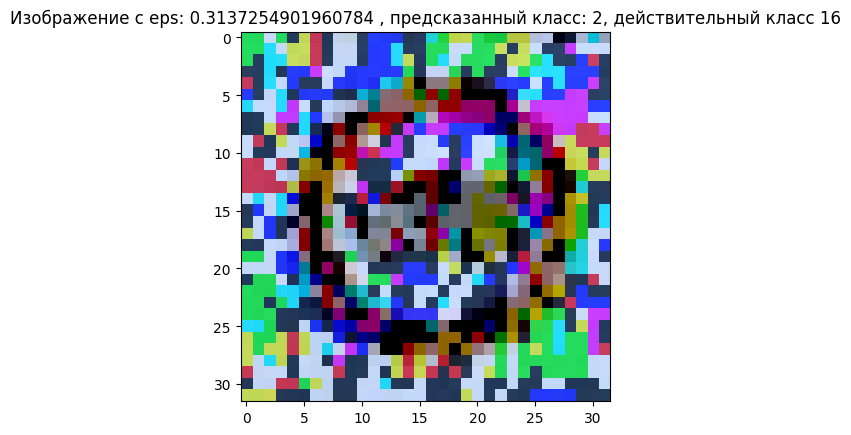

In [24]:
eps_range = [1/255, 5/255, 10/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[0:1]))
plt.figure(0)
plt.title(f"Исходное изображение, предсказанный класс: {pred}, действительный класс {np.argmax(y_test[0])}")
plt.imshow(x_test[0])
plt.show()
i = 1
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[0:1]))
    plt.figure(i)
    plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[0])}")
    plt.imshow(x_test_adv[0])
    plt.show()
    i += 1

Видно, что при росте eps, шум на картинке сильно увеличивается, и с 5/255 уже становится более заметен. Оптимальным eps будет значение от 5/255 до 10/255

### ResNet50 PGD. Подобно FGSM реализуем атаку PGD для различных значений eps

In [25]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [27]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.6852131843566895
Adv Accuracy: 0.7089999914169312
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.00784313725490196
Adv Loss: 3.2105242681503294
Adv Accuracy: 0.5550000071525574
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.011764705882352941
Adv Loss: 4.594104878425598
Adv Accuracy: 0.4090000092983246
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.01568627450980392
Adv Loss: 5.710149248123169
Adv Accuracy: 0.3479999899864197
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.0196078431372549
Adv Loss: 6.554784309387207
Adv Accuracy: 0.30000001192092896
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.03137254901960784
Adv Loss: 7.543270416259766
Adv Accuracy: 0.2549999952316284
True Loss: 0.3387975747585297
True Accuracy: 0.9129999876022339
Eps: 0.0392156862745098
Adv Loss: 8.152194679260253
Adv Accuracy: 0.2280000001192093
True Loss: 0

Точность с eps = 10/255 = 0,039.. менее 60% и равна 23%. С увелечением eps усиливается зашумление картинки, но следовательно и вероятность обнаружения атаки. Отобразим изображения до и после атаки.

In [28]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_rn50", adv_losses_pgd)
np.save("adv_accuracises_pgd_rn50", adv_accuracises_pgd)
!cp adv_losses_pgd_rn50.npy drive/MyDrive/adv_losses_pgd_rn50.npy
!cp adv_accuracises_pgd_rn50.npy drive/MyDrive/adv_accuracises_pgd_rn50.npy

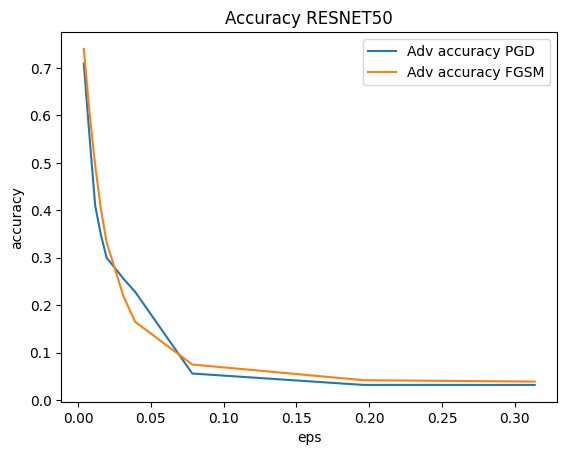

In [29]:
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_rn50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_rn50.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD")
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM")
plt.title("Accuracy RESNET50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()

Из графиков видно, что методы имеют почти схожую эффективность, но метод PGD слегка больше снижает точность. Также видно, что самое большое снижение точности происходит в диапазоне от 0.05 до 0,08. Далее точность снижается гораздо медленне - следовательно значение 0,075 - наиболее эффективное значение для атаки.

### VGG16 FGSM. Создаем модель атаки, которая будет основываться на обученном классификаторе для внесения шума в изображение. Для опрделенных eps нужно вывести изображение после атаки, и класс, которые модель предсказала.

In [30]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [31]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.9882692012786864
Adv Accuracy: 0.7900000214576721
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.00784313725490196
Adv Loss: 3.0189048767089846
Adv Accuracy: 0.6790000200271606
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.011764705882352941
Adv Loss: 3.925011425971985
Adv Accuracy: 0.578000009059906
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.01568627450980392
Adv Loss: 4.673772193908691
Adv Accuracy: 0.49900001287460327
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.0196078431372549
Adv Loss: 5.275397167205811
Adv Accuracy: 0.4350000023841858
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.03137254901960784
Adv Loss: 6.669300437927246
Adv Accuracy: 0.27300000190734863
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.0392156862745098
Adv Loss: 7.2418295173645015
Adv Accuracy: 0.21299999952316284
True Loss: 1.0775812859535217
True 

Точность с eps = 10/255 = 0,039.. менее 60% и равна 21%. С увелечением eps усиливается зашумление картинки, но следовательно и вероятность обнаружения атаки. Отобразим изображения до и после атаки.

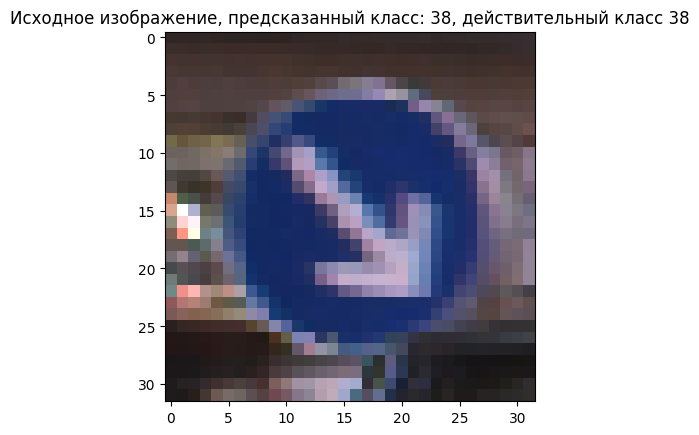

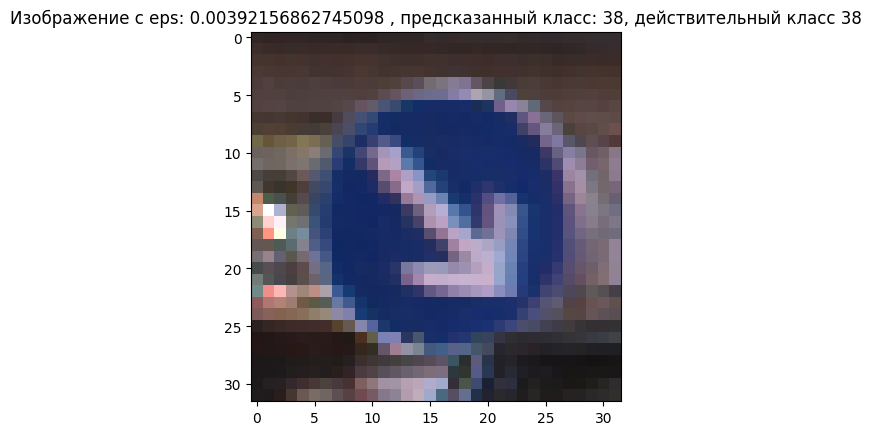

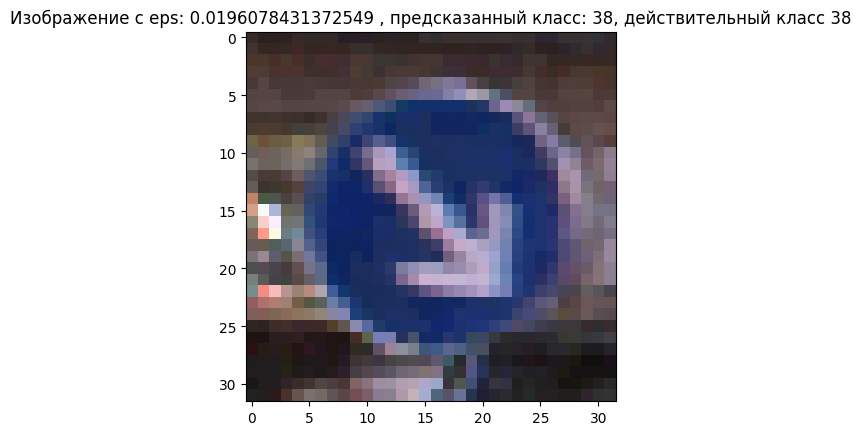

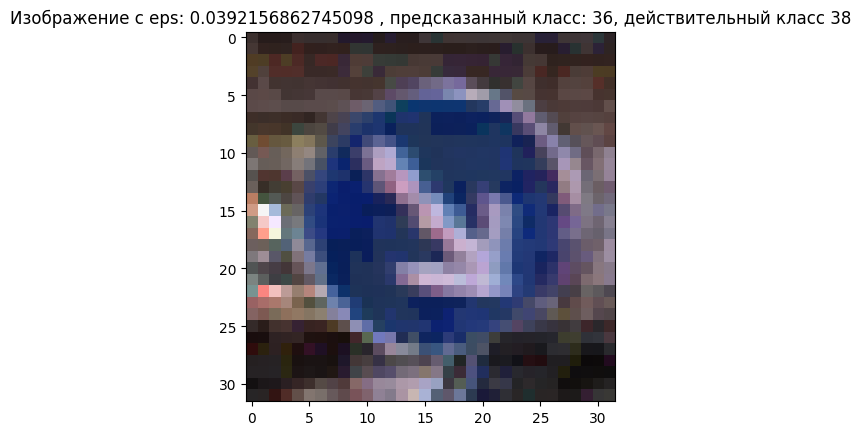

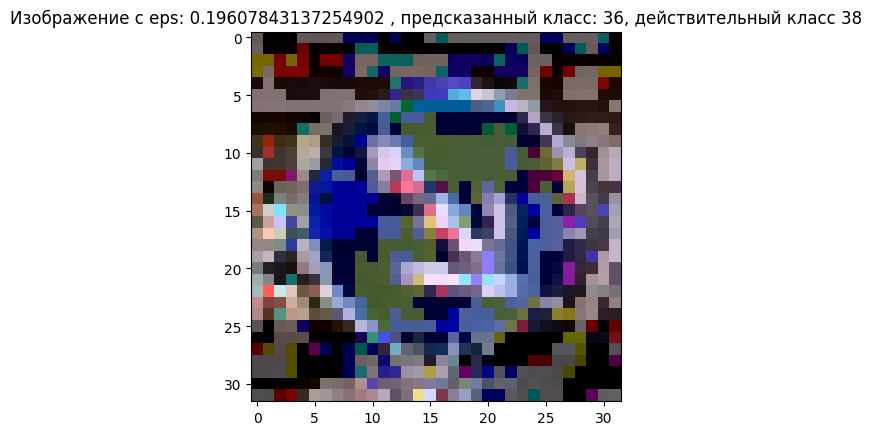

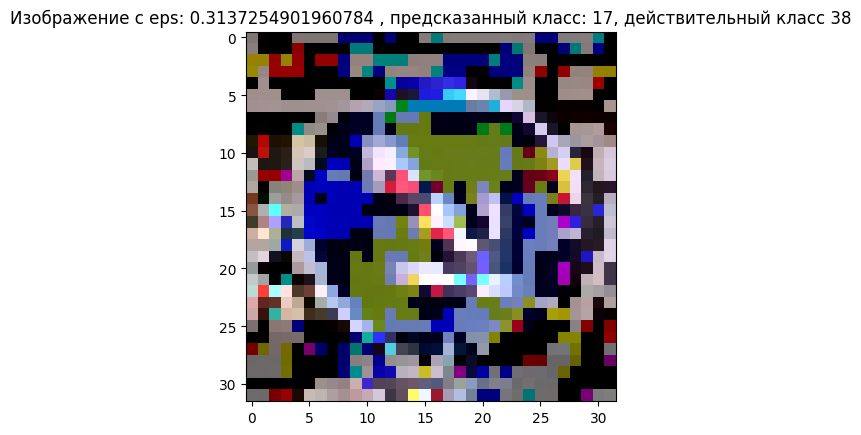

In [37]:
eps_range = [1/255, 5/255, 10/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[2:3]))
plt.figure(0)
plt.title(f"Исходное изображение, предсказанный класс: {pred}, действительный класс {np.argmax(y_test[2])}")
plt.imshow(x_test[2])
plt.show()
i = 1
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[2:3]))
    plt.figure(i)
    plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[2])}")
    plt.imshow(x_test_adv[2])
    plt.show()
    i += 1

In [38]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_vgg16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_vgg16", adv_accuracises_fgsm)
!cp adv_losses_fgsm_vgg16.npy drive/MyDrive/adv_losses_pgd_vgg16.npy
!cp adv_accuracises_fgsm_vgg16.npy drive/MyDrive/adv_accuracises_fgsm_vgg16.npy

### ResNet50 PGD. Подобно FGSM реализуем атаку PGD для различных значений eps

In [39]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [40]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 2.210509747505188
Adv Accuracy: 0.7739999890327454
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.00784313725490196
Adv Loss: 3.6234551582336425
Adv Accuracy: 0.6549999713897705
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.011764705882352941
Adv Loss: 4.5425768547058105
Adv Accuracy: 0.5920000076293945
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.01568627450980392
Adv Loss: 5.764470621109009
Adv Accuracy: 0.5239999890327454
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.0196078431372549
Adv Loss: 6.5568630924224856
Adv Accuracy: 0.4779999852180481
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.03137254901960784
Adv Loss: 8.098874523162841
Adv Accuracy: 0.36899998784065247
True Loss: 1.0775812859535217
True Accuracy: 0.8889999985694885
Eps: 0.0392156862745098
Adv Loss: 8.68859299659729
Adv Accuracy: 0.31700000166893005
True Loss: 

In [41]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_vgg16", adv_losses_pgd)
np.save("adv_accuracises_pgd_vgg16", adv_accuracises_pgd)
!cp adv_losses_pgd_vgg16.npy drive/MyDrive/adv_losses_pgd_vgg16.npy
!cp adv_accuracises_pgd_vgg16.npy drive/MyDrive/adv_accuracises_pgd_vgg16.npy

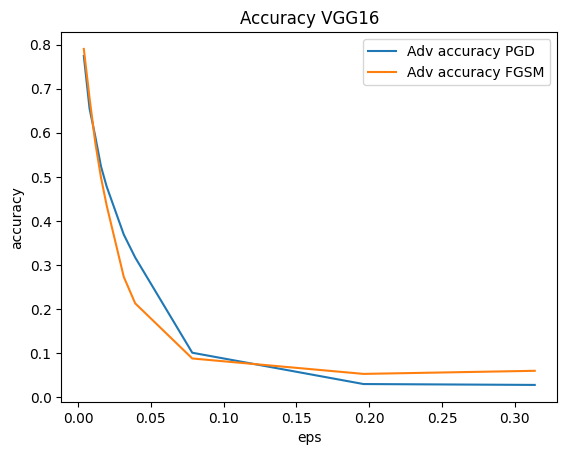

In [42]:
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_vgg16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_vgg16.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD")
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM")
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()

Результаты эксперемента с VGG16 такие же как и с ResNet50

Заполним таблицу 2

| Модель   | Исходные изображения | Adversarial images 𝜖=1/255| Adversarial images 𝜖=5/255 | Adversarial images 𝜖=10/255|
|----------|----------|----------|------|------|
| ResNet50 - FGSM | 91% | 74% |33%|17%
| ResNet50 - PGD   |  91% | 71%  |30%|23%|
| VGG16 - FGSM | 89% | 79%  |44%|21%|
| VGG16 - PGD  | 89% | 77%  |48%|32%|


# Задание 3: Применение целевой атаки уклонения методом белого против моделей глубокого обучения.
В результате данного эесперемента мы должны:
* получить заполенную таблицу с показателями моделей после применения атаки с опрделенным eps для целевой атаки.
* построить примеры исходных изображений и атакующих изображений для различных eps

### Targeted FGSM Attack

In [33]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1
for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

In [4]:
model=load_model('ResNet50.h5')
tf.compat.v1.disable_eager_execution()
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Instructions for updating:
Colocations handled automatically by placer.


Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 0.008428740870914664
Adv Accuracy: 1.0
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.00784313725490196
Adv Loss: 0.15781856303413708
Adv Accuracy: 0.9481481313705444
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.011764705882352941
Adv Loss: 0.5555120750709817
Adv Accuracy: 0.8592592477798462
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.01568627450980392
Adv Loss: 0.8925502626984207
Adv Accuracy: 0.8222222328186035
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.0196078431372549
Adv Loss: 1.198037452167935
Adv Accuracy: 0.7518518567085266
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.03137254901960784
Adv Loss: 2.6630213154686824
Adv Accuracy: 0.47777777910232544
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.0392156862745098
Adv Loss: 3.7823168207097937
Adv Accuracy: 0.27407407760620117
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.0784313725490196
Adv Loss: 5.809915902879503
Adv A

In [51]:
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

Выведем 5 примеров классификации класса 14 как класс 1 при помощи целевой FGSM атаки

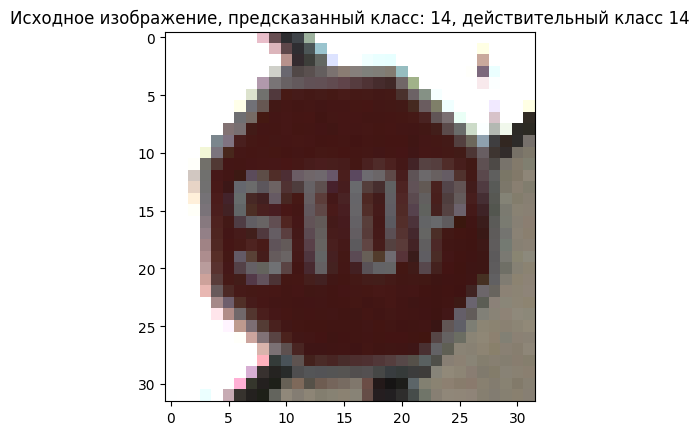

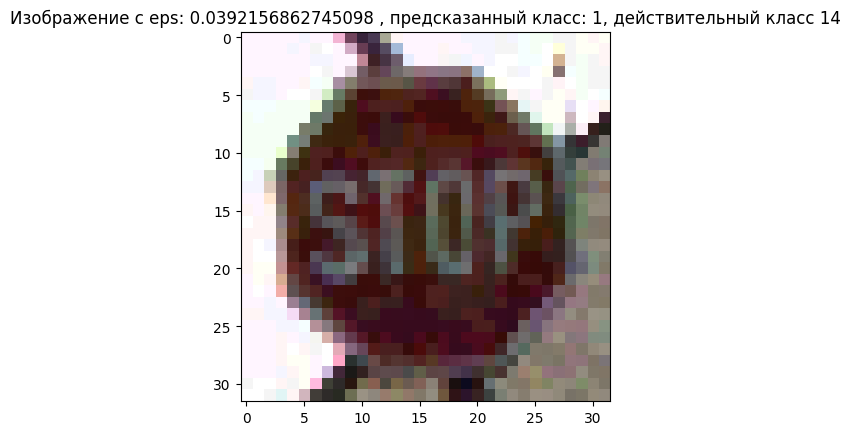

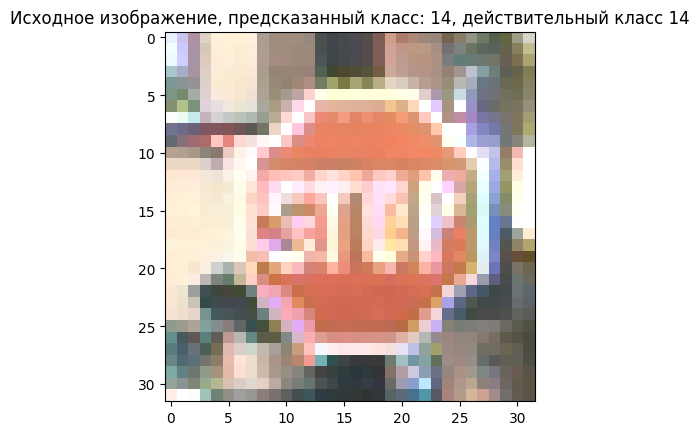

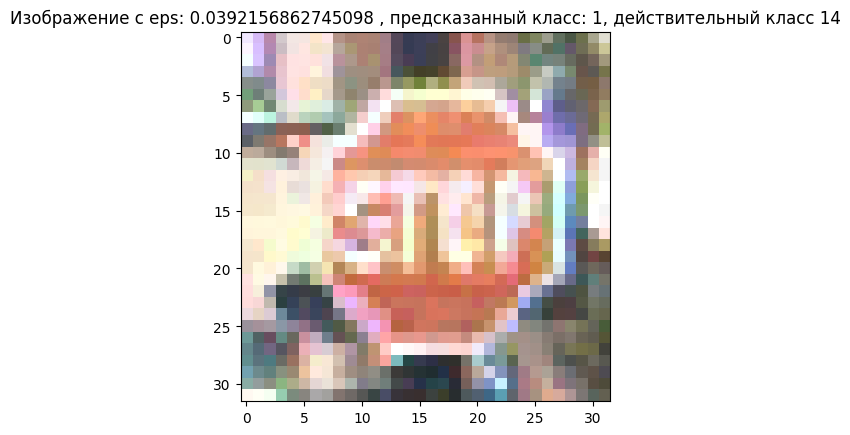

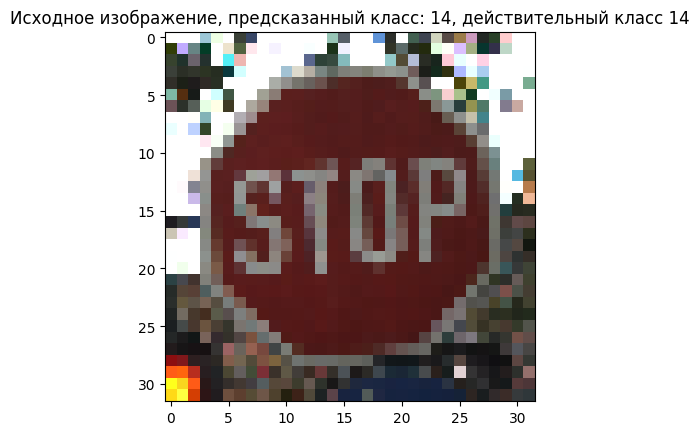

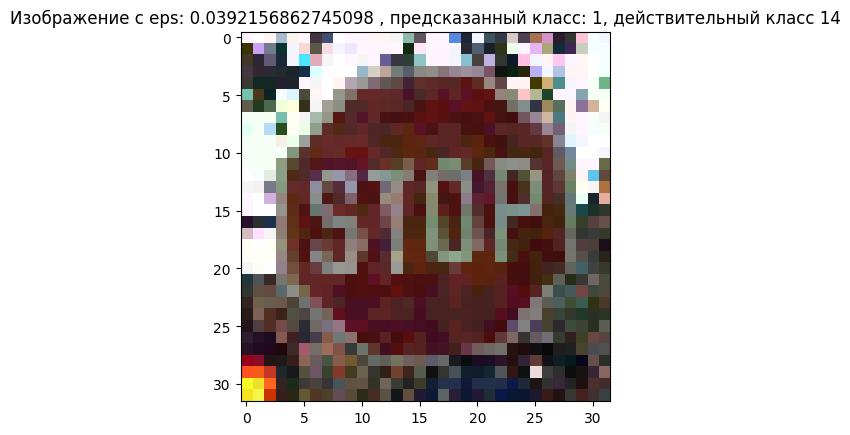

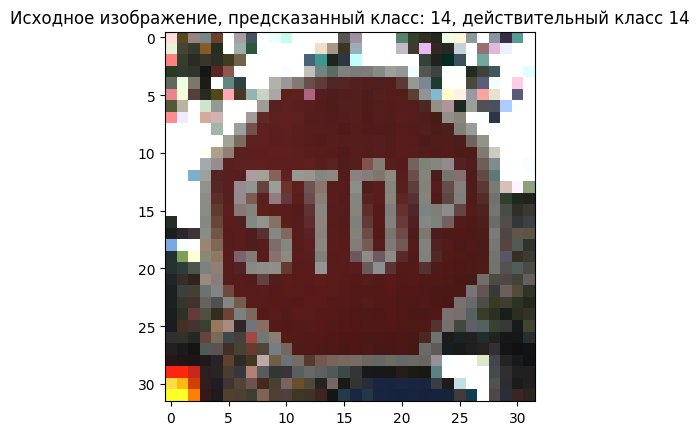

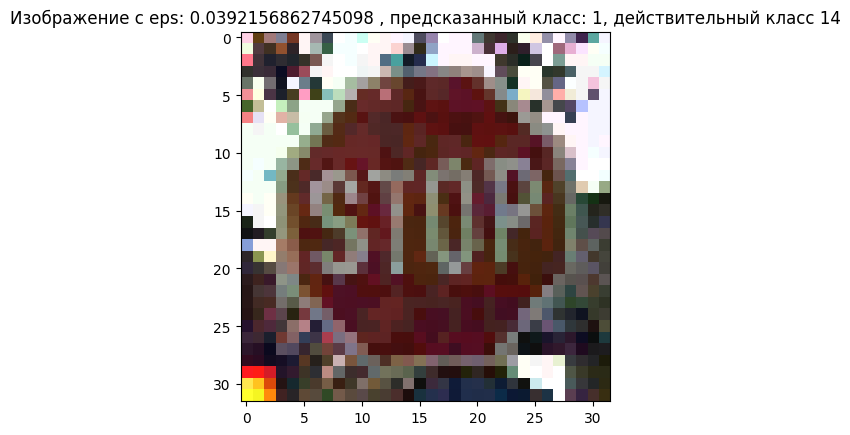

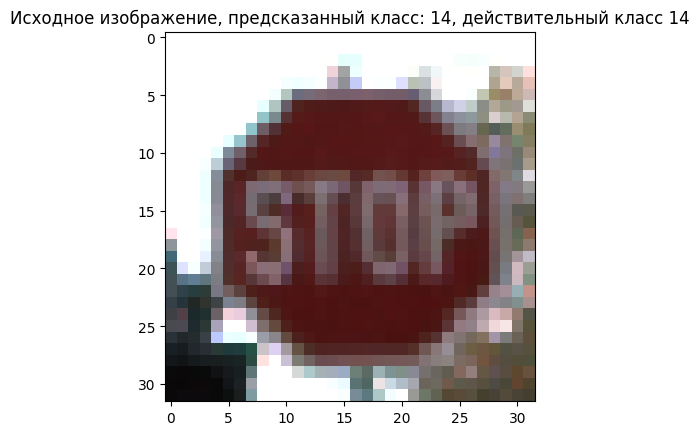

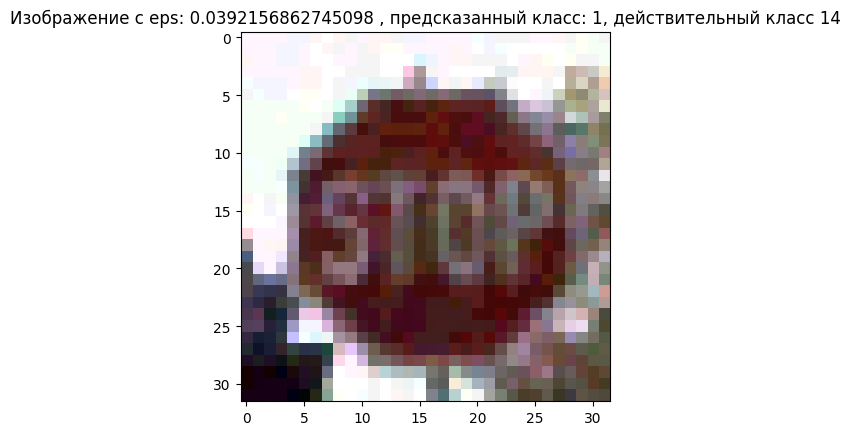

In [31]:
range = [0, 3, 5, 6 , 8]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Исходное изображение, предсказанный класс: {pred}, действительный класс {np.argmax(y_test[index])}")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[index])}")
  plt.imshow(x_test_adv[index])
  plt.show()

### Targeted PGD Attack

In [35]:
model=load_model('ResNet50.h5')
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 0.009793413682254377
Adv Accuracy: 0.9925925731658936
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.00784313725490196
Adv Loss: 0.17940131547274413
Adv Accuracy: 0.9518518447875977
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.011764705882352941
Adv Loss: 0.3999686049090491
Adv Accuracy: 0.9074074029922485
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.01568627450980392
Adv Loss: 0.2361312265749331
Adv Accuracy: 0.9370370507240295
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.0196078431372549
Adv Loss: 0.26182497007151445
Adv Accuracy: 0.9259259104728699
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.03137254901960784
Adv Loss: 0.8208330657747057
Adv Accuracy: 0.7740740776062012
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.0392156862745098
Adv Loss: 1.126944582550614
Adv Accuracy: 0.6925926208496094
True Loss: 1.7245509688682097e-05
True Accuracy: 1.0
Eps: 0.0784313725490196
Adv Loss: 3.0877684

In [52]:
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

Выведем 5 примеров классификации класса 14 как класс 1 при помощи целевой PGD атаки

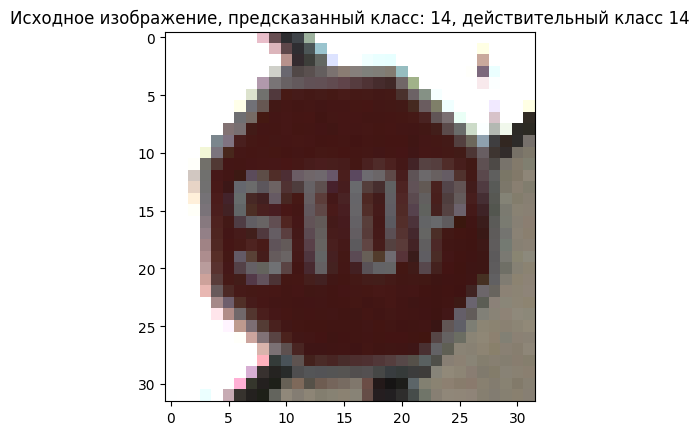

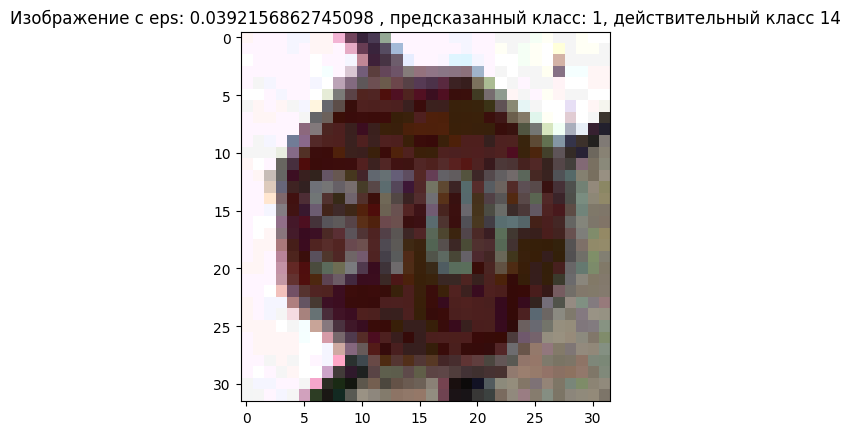

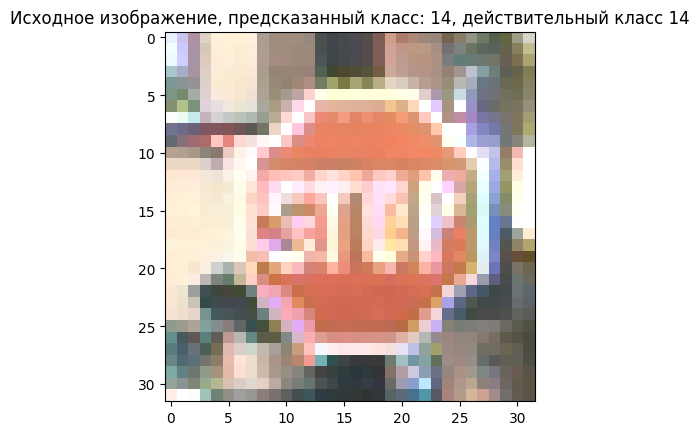

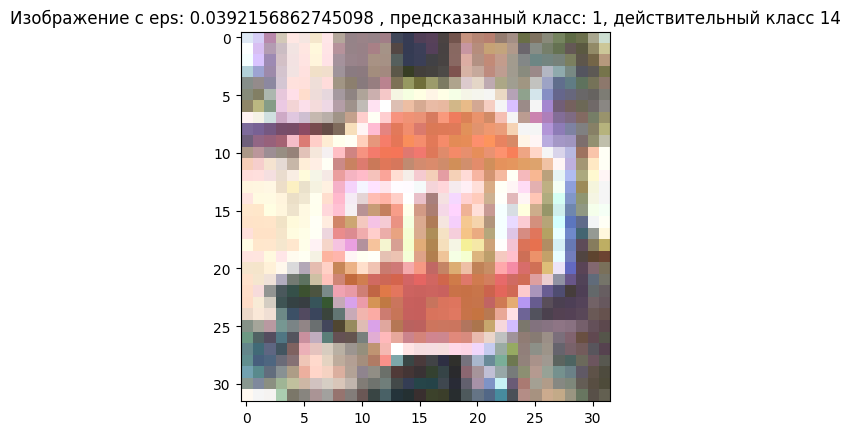

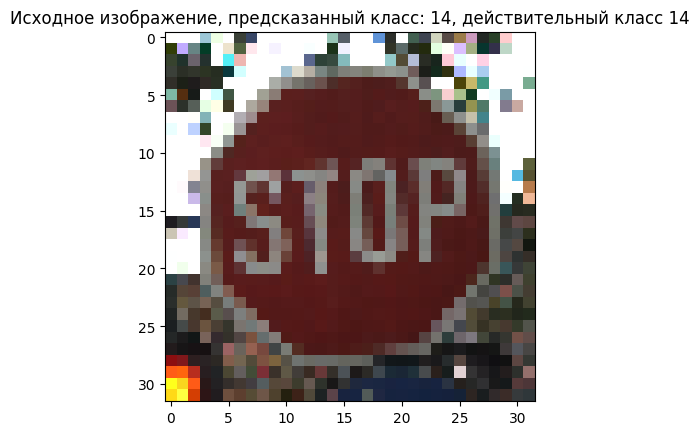

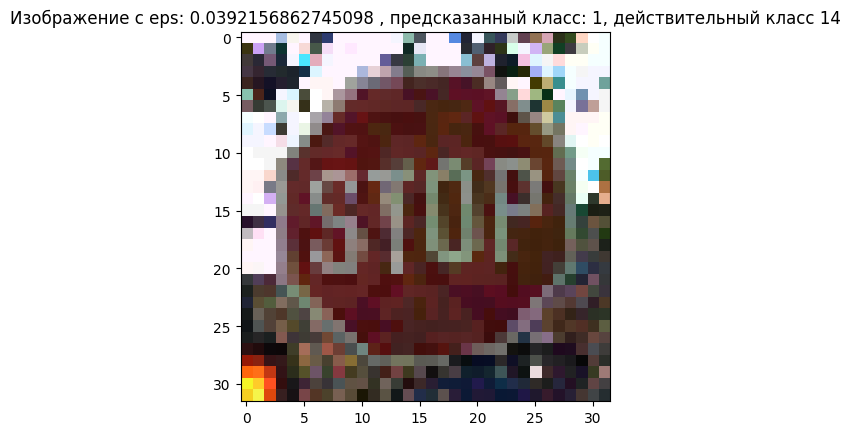

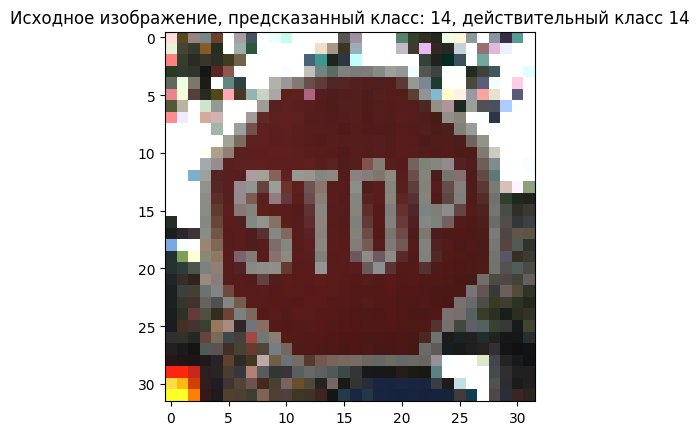

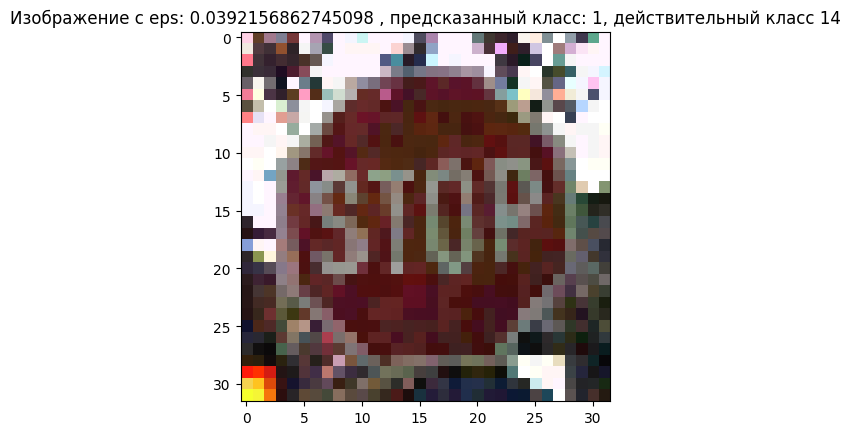

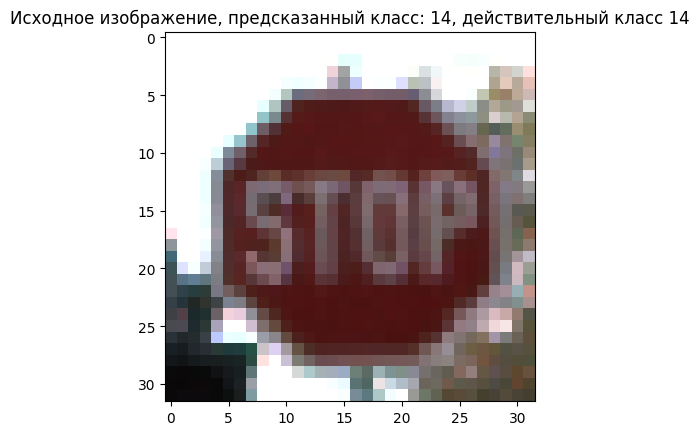

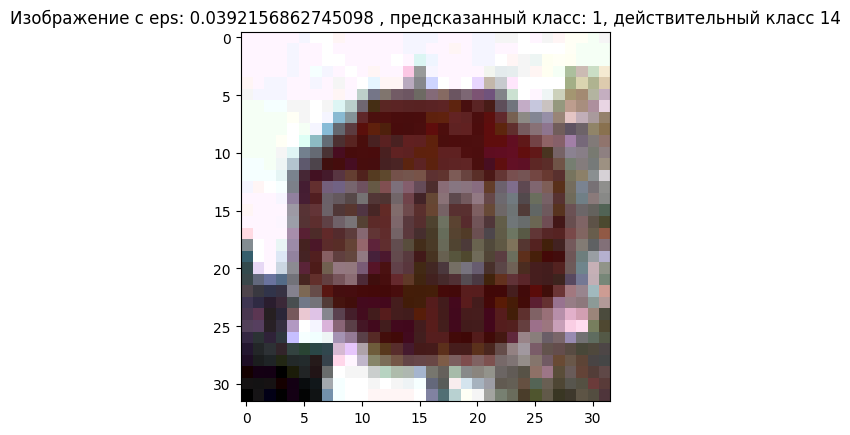

In [47]:
range = [0, 3, 5, 6 , 8]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Исходное изображение, предсказанный класс: {pred}, действительный класс {np.argmax(y_test[index])}")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[index])}")
  plt.imshow(x_test_adv[index])
  plt.show()

Заполним итоговую таблицу точностей целевых атак PGD и FGSM на знак стоп (label 14), с цель классификации как Speed Limit 30 (label 1)


| Искажение  | PGD attack – Stop sign images | FGSM attack – Stop sign images|
|----------|----------|----------|
| 𝜖=1/255 | 99% | 100% |
| 𝜖=3/255 |  90% | 85%  |
| 𝜖=5/255 | 92% | 75%  |
| 𝜖=10/255 | 70% | 27%  |
| 𝜖=20/255 | 60% | 3%  |
| 𝜖=50/255 | 1% | 0%  |
| 𝜖=80/255 | 1% | 0%  |

Результат таков:
* метод FGSM для целевых атак применять не следует, с ростом eps и соответственно шума, классификация действительно ошибочна, однако класс который мы хотим навязать модели, наиболее точно определяется при eps **10/255**, далее модель будет определять совсем не те значения, что мы указали (не label 1).
* PGD отлично подходит для целевой атаки, при больших eps модель почти всегда будет определять класс 14 как 1, но изображение будет слишком зашумленным, для данной атаки - оптимальным значением будет **50/255**, такие значения eps сильно зашумляют изображение, но и  классификация класса 1 как класса 14 будет наиболее выраженой.

*Необходимо искать золотую середину между вероятностью классификации изображения как класс 1 и силой зашумленности картинки. Но как для целевой атаки PGD в целом оптимальное значение - 50/255*

In [49]:
eps = 50/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)
pred = model.predict(x_test_adv)
index = 0
for pr in pred:
  print(f"{index}: predicted: {np.argmax(pr)}")
  index +=1

0: predicted: 1
1: predicted: 1
2: predicted: 1
3: predicted: 1
4: predicted: 1
5: predicted: 1
6: predicted: 1
7: predicted: 1
8: predicted: 1
9: predicted: 1
10: predicted: 13
11: predicted: 14
12: predicted: 1
13: predicted: 1
14: predicted: 1
15: predicted: 1
16: predicted: 30
17: predicted: 1
18: predicted: 1
19: predicted: 1
20: predicted: 1
21: predicted: 1
22: predicted: 1
23: predicted: 1
24: predicted: 1
25: predicted: 1
26: predicted: 1
27: predicted: 1
28: predicted: 1
29: predicted: 1
30: predicted: 1
31: predicted: 1
32: predicted: 1
33: predicted: 1
34: predicted: 1
35: predicted: 1
36: predicted: 1
37: predicted: 1
38: predicted: 1
39: predicted: 1
40: predicted: 1
41: predicted: 1
42: predicted: 1
43: predicted: 1
44: predicted: 1
45: predicted: 1
46: predicted: 1
47: predicted: 1
48: predicted: 1
49: predicted: 1
50: predicted: 1
51: predicted: 1
52: predicted: 1
53: predicted: 1
54: predicted: 1
55: predicted: 1
56: predicted: 1
57: predicted: 1
58: predicted: 1
59: 

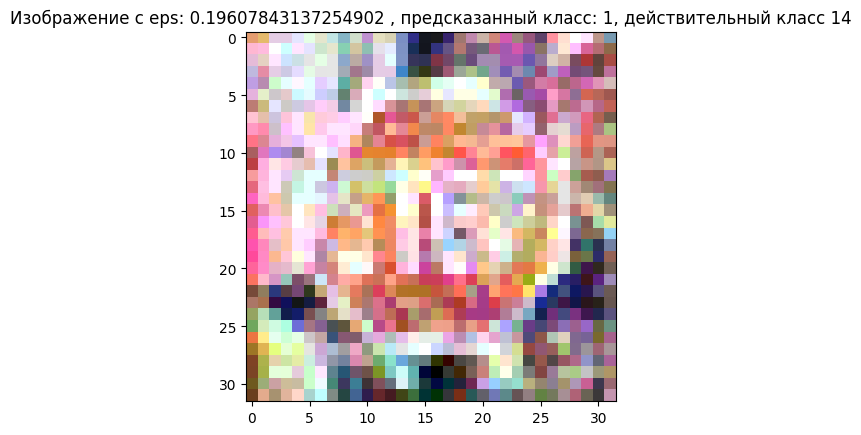

In [50]:
pred = np.argmax(model.predict(x_test_adv[268:269]))
plt.figure(0)
plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[268])}")
plt.imshow(x_test_adv[268])
plt.show()